# Data 606 - Capstone Project
###Movie Recommendation System

Goal of this project: To explore recommendation system on the movie dataset with both content-based method and collaborative method using Machine Learning Algorithms. 

Outline for this project:
1. EDA
2. Data prep. Singular Value Decomposition (SVD)atioNeural network-based Collaborative Filtering(NCF)tering

### Collaborative Filtering (Singular Value Decomposition)


In [3]:
from surprise import SVD, accuracy, SVDpp
from surprise.model_selection import cross_validate
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from surprise import Dataset
from sklearn.metrics import accuracy_score
path='C:\\Users\\kamho\\OneDrive\\Documents\\GitHub\\movieRecommendationSystem\\MRS_repo\\data\\raw\\Data3_movielens\\'
path2='C:\\Users\\kamho\\OneDrive\\Documents\\GitHub\\movieRecommendationSystem\\MRS_repo\\data\\raw\\ml-latest\\'
ratings_filename = 'ratings.csv'

In [4]:
df_rating = pd.read_csv(os.path.join(path2, ratings_filename))



In [5]:
df_rating.rating.value_counts()

4.0    7394710
3.0    5515668
5.0    4071135
3.5    3404360
4.5    2373550
2.0    1850627
2.5    1373419
1.0     886233
0.5     442388
1.5     441354
Name: rating, dtype: int64

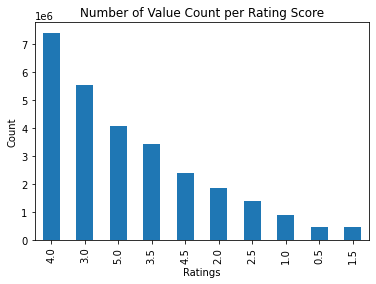

In [129]:
df_rating.rating.value_counts().plot(kind='bar')
plt.title('Number of Value Count per Rating Score')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

In [6]:
#Check if there is null value in the df_rating dataset
df_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27753444 entries, 0 to 27753443
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 847.0 MB


In [7]:
df_rating.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [8]:
#Drop the timestamp column as we don't need for SVD
df_rating = df_rating.drop(columns='timestamp')
df_rating.head()

,userId,movieId,rating
0,1,307,3.5
1,1,481,3.5
2,1,1091,1.5
3,1,1257,4.5
4,1,1449,4.5


from sklearn import preprocessing
d = preprocessing.normalize(df_rating)
df_rating = pd.DataFrame(d, columns=df_rating.columns)



In [9]:
#Loading the df_rating from a pandas dataframe using load_from_df() method and reader object
from surprise import Reader, Dataset
reader = Reader(rating_scale=(0.5,5))
data = Dataset.load_from_df(df_rating[['userId', 'movieId', 'rating']], reader)

In [10]:
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=0.20, random_state=1)

#### SVD algorithm is equivalent to Probabilistic Matrix Factorization

In [11]:
#Using the SVD algorithm
algo = SVD()
#Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)

In [12]:
predictions = algo.test(testset)

In [13]:
df_result= pd.DataFrame(predictions)

In [14]:
df_result

,uid,iid,r_ui,est,details
0,215293,648,3.0,3.377608,{'was_impossible': False}
1,124108,1584,4.0,4.037333,{'was_impossible': False}
2,130033,181,3.5,2.122329,{'was_impossible': False}
3,167679,4027,4.5,3.951787,{'was_impossible': False}
4,103232,7254,4.0,4.237421,{'was_impossible': False}
...,...,...,...,...,...
5550684,4967,3703,3.0,2.962443,{'was_impossible': False}
5550685,126308,719,4.0,3.556963,{'was_impossible': False}
5550686,69452,3361,4.0,3.362125,{'was_impossible': False}
5550687,219331,919,5.0,3.828199,{'was_impossible': False}


In [15]:
def round_of_rating(number):
    return round(number*2)/2

In [16]:
df_result['est'] = round_of_rating(df_result['est'])
df_result['r_ui'] = round_of_rating(df_result['r_ui'])

In [17]:
df_result['r_ui'] = df_result['r_ui'].astype(str)
df_result['est'] = df_result['est'].astype(str)

In [24]:
df_result

,uid,iid,r_ui,est,details
0,215293,648,3.0,3.5,{'was_impossible': False}
1,124108,1584,4.0,4.0,{'was_impossible': False}
2,130033,181,3.5,2.0,{'was_impossible': False}
3,167679,4027,4.5,4.0,{'was_impossible': False}
4,103232,7254,4.0,4.0,{'was_impossible': False}
...,...,...,...,...,...
5550684,4967,3703,3.0,3.0,{'was_impossible': False}
5550685,126308,719,4.0,3.5,{'was_impossible': False}
5550686,69452,3361,4.0,3.5,{'was_impossible': False}
5550687,219331,919,5.0,4.0,{'was_impossible': False}


In [18]:
y_true = list(df_result['r_ui'])
y_pred = list(df_result['est']) 

In [21]:
accuracy_score(y_true,y_pred)

0.28825232327013817

In [23]:
accuracy.rmse(predictions)

RMSE: 0.7950


0.7949888833486511

In [20]:
cross_validate_svd = cross_validate(algo, data, measures = ['RMSE'],cv=5,verbose=True) 

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8777  0.8694  0.8782  0.8735  0.8698  0.8737  0.0038  
Fit time          3.77    3.65    3.73    3.58    3.65    3.68    0.07    
Test time         0.11    0.15    0.11    0.14    0.10    0.12    0.02    


#### The SVDpp algorithm is an extension of SVD that takes into account implicit ratings which has been used in netflix competition.

In [21]:
#Using The SVD++ algo
algo= SVDpp()

#train the dataset on the SVD++ algo
algo.fit(trainset)

In [22]:
predictions = algo.test(testset)

In [ ]:
df_result= pd.DataFrame(predictions)

In [ ]:
df_result['est'] = round_of_rating(df_result['est'])
df_result['r_ui'] = round_of_rating(df_result['r_ui'])
df_result['r_ui'] = df_result['r_ui'].astype(str)
df_result['est'] = df_result['est'].astype(str)

In [ ]:
y_true = list(df_result['r_ui'])
y_pred = list(df_result['est']) 
accuracy_score(y_true,y_pred)

In [23]:
accuracy.rmse(predictions)

RMSE: 0.8616


0.8615934492809341

In [28]:
cross_validate(algo, data, measures = ['RMSE'],cv=5,verbose=True) 

Evaluating RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8618  0.8709  0.8607  0.8571  0.8565  0.8614  0.0052  
Fit time          389.74  382.01  372.76  371.30  371.60  377.48  7.29    
Test time         6.69    5.97    5.91    6.06    6.00    6.13    0.29    


{'test_rmse': array([0.86177561, 0.87093908, 0.86074049, 0.85714087, 0.85647745]),
 'fit_time': (389.73703026771545,
  382.0073707103729,
  372.7553939819336,
  371.30277132987976,
  371.6013720035553),
 'test_time': (6.690812110900879,
  5.971331834793091,
  5.914973974227905,
  6.063922882080078,
  5.996409893035889)}

In [29]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from datetime import datetime

np.random.seed(123)

In [30]:
path2='C:\\Users\\kamho\\OneDrive\\Documents\\GitHub\\movieRecommendationSystem\\MRS_repo\\data\\raw\\kaggle_movielens\\'
df_rating = pd.read_csv(os.path.join(path, ratings_filename))


In [31]:
df_rating['timestamp']=df_rating.timestamp.apply(lambda x: datetime.fromtimestamp(x / 1e3))

In [32]:
df_rating

,userId,movieId,rating,timestamp
0,1,1,4.0,1970-01-11 23:03:02.703
1,1,3,4.0,1970-01-11 23:03:01.247
2,1,6,4.0,1970-01-11 23:03:02.224
3,1,47,5.0,1970-01-11 23:03:03.815
4,1,50,5.0,1970-01-11 23:03:02.931
...,...,...,...,...
100831,610,166534,4.0,1970-01-18 01:57:28.402
100832,610,168248,5.0,1970-01-18 01:57:30.091
100833,610,168250,5.0,1970-01-18 02:04:33.047
100834,610,168252,5.0,1970-01-18 01:57:26.352


In [33]:
print('There are {} rows of data from {} users'.format(len(df_rating), len(df_rating['userId'].unique())))

There are 100836 rows of data from 610 users


In [46]:
df_rating

,userId,movieId,rating,timestamp,rank_latest
0,1,1,4.0,1970-01-11 23:03:02.703,86.0
1,1,3,4.0,1970-01-11 23:03:01.247,196.0
2,1,6,4.0,1970-01-11 23:03:02.224,141.0
3,1,47,5.0,1970-01-11 23:03:03.815,18.0
4,1,50,5.0,1970-01-11 23:03:02.931,66.0
...,...,...,...,...,...
100831,610,166534,4.0,1970-01-18 01:57:28.402,314.0
100832,610,168248,5.0,1970-01-18 01:57:30.091,95.0
100833,610,168250,5.0,1970-01-18 02:04:33.047,23.0
100834,610,168252,5.0,1970-01-18 01:57:26.352,615.0


In [47]:
#split our ratings dataset into a train and test set using the leave-one-out methodology
df_rating['rank_latest'] = df_rating.groupby(['userId'])['timestamp'] \
                                .rank(method='first', ascending=False)
df_rating

,userId,movieId,rating,timestamp,rank_latest
0,1,1,4.0,1970-01-11 23:03:02.703,86.0
1,1,3,4.0,1970-01-11 23:03:01.247,196.0
2,1,6,4.0,1970-01-11 23:03:02.224,141.0
3,1,47,5.0,1970-01-11 23:03:03.815,18.0
4,1,50,5.0,1970-01-11 23:03:02.931,66.0
...,...,...,...,...,...
100831,610,166534,4.0,1970-01-18 01:57:28.402,314.0
100832,610,168248,5.0,1970-01-18 01:57:30.091,95.0
100833,610,168250,5.0,1970-01-18 02:04:33.047,23.0
100834,610,168252,5.0,1970-01-18 01:57:26.352,615.0


In [48]:
#Using earlier review for trainning, and using latest review for testing
train_ratings = df_rating[df_rating['rank_latest'] != 1]
test_ratings = df_rating[df_rating['rank_latest'] == 1]
train_ratings


,userId,movieId,rating,timestamp,rank_latest
0,1,1,4.0,1970-01-11 23:03:02.703,86.0
1,1,3,4.0,1970-01-11 23:03:01.247,196.0
2,1,6,4.0,1970-01-11 23:03:02.224,141.0
3,1,47,5.0,1970-01-11 23:03:03.815,18.0
4,1,50,5.0,1970-01-11 23:03:02.931,66.0
...,...,...,...,...,...
100831,610,166534,4.0,1970-01-18 01:57:28.402,314.0
100832,610,168248,5.0,1970-01-18 01:57:30.091,95.0
100833,610,168250,5.0,1970-01-18 02:04:33.047,23.0
100834,610,168252,5.0,1970-01-18 01:57:26.352,615.0


In [49]:
#Converting the dataset into an implicit feedback dataset
#Binarize the ratings to 1 means the user has interacted with the movie
train_ratings.loc[:, 'rating'] = 1
train_ratings.sample(10)

C:\Python\Python37\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,userId,movieId,rating,timestamp,rank_latest
10166,66,2716,1,1970-01-13 10:49:07.713,262.0
36252,247,5989,1,1970-01-17 18:40:45.413,62.0
48952,317,88129,1,1970-01-17 08:21:53.016,87.0
28763,199,2527,1,1970-01-11 16:13:00.371,302.0
50337,325,2268,1,1970-01-12 19:43:16.675,170.0
17205,109,1032,1,1970-01-10 12:39:12.033,17.0
91198,590,53125,1,1970-01-15 08:33:48.766,183.0
67198,434,2762,1,1970-01-15 11:56:44.701,130.0
96205,603,426,1,1970-01-11 19:58:45.774,832.0
72499,469,551,1,1970-01-11 23:10:25.487,136.0


In [50]:
# Generate negative samples to train our models
# Get a list of all movie IDs
all_movieIds = df_rating['movieId'].unique()

# Placeholders that will hold the training data
users, items, labels = [], [], []

# This is the set of items that each user has interaction with
user_item_set = set(zip(train_ratings['userId'], train_ratings['movieId']))

# 4:1 ratio of negative to positive samples
num_negatives = 4

for (u, i) in tqdm(user_item_set):
    users.append(u)
    items.append(i)
    labels.append(1) # items that the user has interacted with are positive
    for _ in range(num_negatives):
        # randomly select an item
        negative_item = np.random.choice(all_movieIds) 
        # check that the user has not interacted with this item
        while (u, negative_item) in user_item_set:
            negative_item = np.random.choice(all_movieIds)
        users.append(u)
        items.append(negative_item)
        labels.append(0) # items not interacted with are negative

100%|██████████| 100226/100226 [00:04<00:00, 22064.75it/s]


In [51]:
class MovieLensTrainDataset(Dataset):
    """MovieLens PyTorch Dataset for Training
    
    Args:
        ratings (pd.DataFrame): Dataframe containing the movie ratings
        all_movieIds (list): List containing all movieIds
    
    """

    def __init__(self, ratings, all_movieIds):
        self.users, self.items, self.labels = self.get_dataset(ratings, all_movieIds)

    def __len__(self):
        return len(self.users)
  
    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.labels[idx]

    def get_dataset(self, ratings, all_movieIds):
        users, items, labels = [], [], []
        user_item_set = set(zip(ratings['userId'], ratings['movieId']))

        num_negatives = 4
        for u, i in user_item_set:
            users.append(u)
            items.append(i)
            labels.append(1)
            for _ in range(num_negatives):
                negative_item = np.random.choice(all_movieIds)
                while (u, negative_item) in user_item_set:
                    negative_item = np.random.choice(all_movieIds)
                users.append(u)
                items.append(negative_item)
                labels.append(0)

        return torch.tensor(users), torch.tensor(items), torch.tensor(labels)

In [52]:
class NCF(pl.LightningModule):
    """ Neural Collaborative Filtering (NCF)
    
        Args:
            num_users (int): Number of unique users
            num_items (int): Number of unique items
            ratings (pd.DataFrame): Dataframe containing the movie ratings for training
            all_movieIds (list): List containing all movieIds (train + test)
    """
    
    def __init__(self, num_users, num_items, ratings, all_movieIds):
        super().__init__()
        self.user_embedding = nn.Embedding(num_embeddings=num_users, embedding_dim=8)
        self.item_embedding = nn.Embedding(num_embeddings=num_items, embedding_dim=8)
        self.fc1 = nn.Linear(in_features=16, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=32)
        self.output = nn.Linear(in_features=32, out_features=1)
        self.ratings = ratings
        self.all_movieIds = all_movieIds
        
    def forward(self, user_input, item_input):
        
        # Pass through embedding layers
        user_embedded = self.user_embedding(user_input)
        item_embedded = self.item_embedding(item_input)

        # Concat the two embedding layers
        vector = torch.cat([user_embedded, item_embedded], dim=-1)

        # Pass through dense layer
        vector = nn.ReLU()(self.fc1(vector))
        vector = nn.ReLU()(self.fc2(vector))

        # Output layer
        pred = nn.Sigmoid()(self.output(vector))

        return pred
    
    def training_step(self, batch, batch_idx):
        user_input, item_input, labels = batch
        predicted_labels = self(user_input, item_input)
        loss = nn.BCELoss()(predicted_labels, labels.view(-1, 1).float())
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

    def train_dataloader(self):
        return DataLoader(MovieLensTrainDataset(self.ratings, self.all_movieIds),
                          batch_size=512, num_workers=1)

In [53]:
num_users = df_rating['userId'].max()+1
num_items = df_rating['movieId'].max()+1

all_movieIds = df_rating['movieId'].unique()

model = NCF(num_users, num_items, train_ratings, all_movieIds)

In [54]:
import pytorch_lightning as pl
print(torch.__version__)
print(pl.__version__)


1.8.1+cu102
1.2.10


In [56]:
trainer = pl.Trainer(max_epochs=5, gpus=1, reload_dataloaders_every_epoch=True,
                     progress_bar_refresh_rate=50, logger=False, checkpoint_callback=False)

trainer.fit(model)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]

  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 4.9 K 
1 | item_embedding | Embedding | 1.5 M 
2 | fc1            | Linear    | 1.1 K 
3 | fc2            | Linear    | 2.1 K 
4 | output         | Linear    | 33    
---------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.228     Total estimated model params size (MB)
Epoch 0:   0%|          | 0/979 [00:05<?, ?it/s]


RuntimeError: DataLoader worker (pid(s) 38212) exited unexpectedly